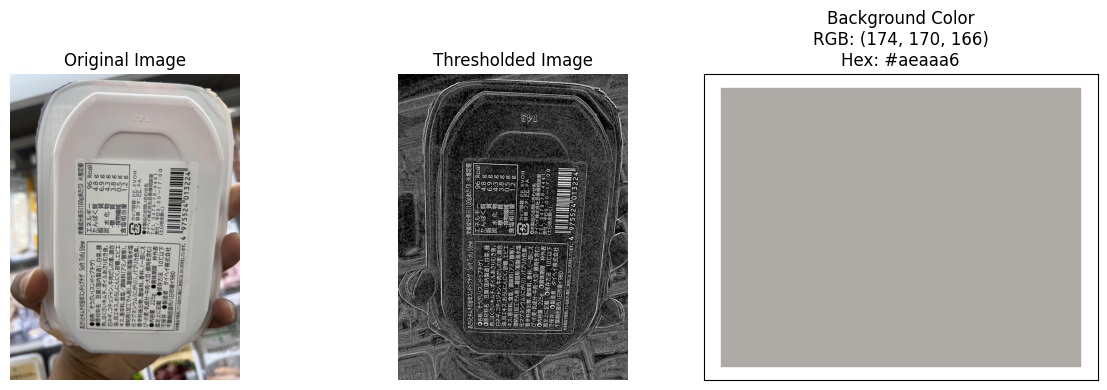

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
def get_document_background_color(image_path, visualize=True):

    try:
        # Read the image
        image = cv2.imread(image_path)

        # Check if image is loaded successfully
        if image is None:
            raise ValueError(f"Unable to read image from {image_path}")

        # Convert to RGB for visualization
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding
        thresh = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 21, 2
        )

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour (likely the document)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)

            # Create a mask for the document
            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [largest_contour], 0, 255, -1)

            # Extract background pixels
            background_pixels = image_rgb[mask == 0]

            if len(background_pixels) > 0:
                # Use the median of background pixels as the background color
                background_color = tuple(map(int, np.median(background_pixels, axis=0)))
                hex_color = '#{:02x}{:02x}{:02x}'.format(*background_color)

                # Visualization
                if visualize:
                    plt.figure(figsize=(12, 4))

                    plt.subplot(131)
                    plt.title("Original Image")
                    plt.imshow(image_rgb)
                    plt.axis('off')

                    plt.subplot(132)
                    plt.title("Thresholded Image")
                    plt.imshow(thresh, cmap='gray')
                    plt.axis('off')

                    plt.subplot(133)
                    plt.title(f"Background Color\nRGB: {background_color}\nHex: {hex_color}")
                    plt.fill_between([0,1], [0,0], [1,1], color=tuple(c/255 for c in background_color))
                    plt.xticks([])
                    plt.yticks([])

                    plt.tight_layout()
                    plt.show()

                return {
                    'rgb': background_color,
                    'hex': hex_color,
                    'method': 'document_background'
                }

        # Fallback: use overall image color if document detection fails
        pixels = image_rgb.reshape(-1, 3)
        background_color = tuple(map(int, np.median(pixels, axis=0)))
        hex_color = '#{:02x}{:02x}{:02x}'.format(*background_color)

        # Visualization for fallback method
        if visualize:
            plt.figure(figsize=(12, 4))

            plt.subplot(131)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')

            plt.subplot(132)
            plt.title("Thresholded Image")
            plt.imshow(thresh, cmap='gray')
            plt.axis('off')

            plt.subplot(133)
            plt.title(f"Background Color (Fallback)\nRGB: {background_color}\nHex: {hex_color}")
            plt.fill_between([0,1], [0,0], [1,1], color=tuple(c/255 for c in background_color))
            plt.xticks([])
            plt.yticks([])

            plt.tight_layout()
            plt.show()

        return {
            'rgb': background_color,
            'hex': hex_color,
            'method': 'overall_image'
        }

    except Exception as e:
        print(f"Error processing image: {e}")
        return None



# Example usage
if __name__ == "__main__":
    # Single image processing
    image_path = '/content/converted_image.jpg'
    color_result = get_document_background_color(image_path)

    # If you want to process multiple images
    # image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
    # batch_results = batch_process_images(image_paths)

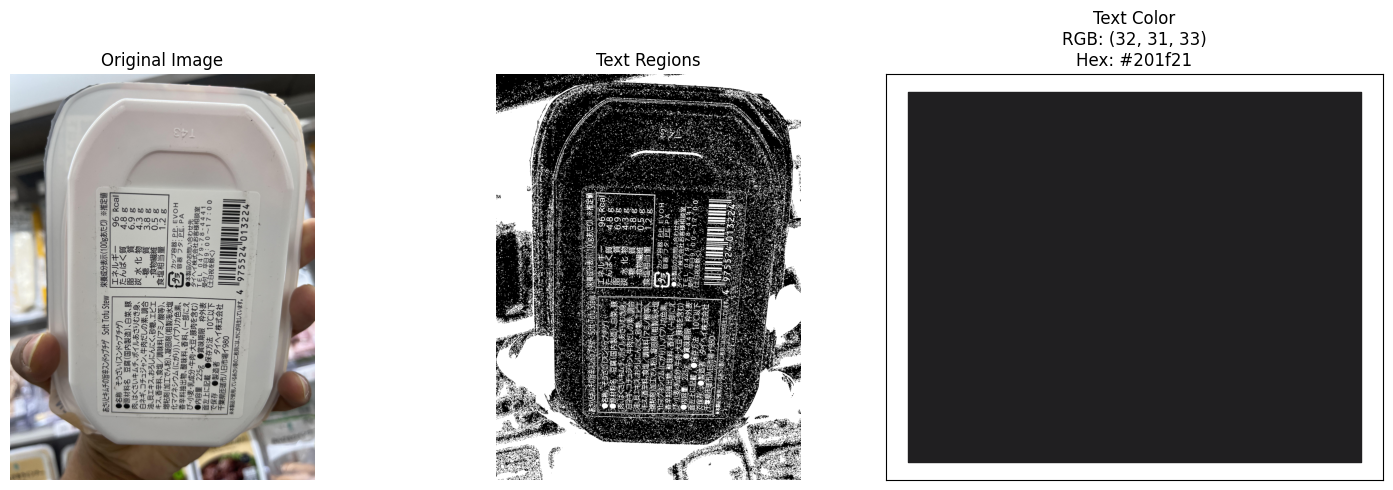

Text Color - RGB: (32, 31, 33), Hex: #201f21


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def get_text_color(image_path, visualize=True):
    """
    Advanced text color detection with multiple analysis techniques

    Parameters:
    -----------
    image_path : str
        Path to the input image file
    visualize : bool, optional
        Whether to display a visualization of the detected color (default is True)

    Returns:
    --------
    dict or None
        A dictionary containing text color information
    """
    try:
        # Read the image
        image = cv2.imread(image_path)

        # Check if image is loaded successfully
        if image is None:
            raise ValueError(f"Unable to read image from {image_path}")

        # Convert to RGB for visualization
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply multiple preprocessing techniques
        # 1. Adaptive Thresholding
        thresh1 = cv2.adaptiveThreshold(
            gray, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY_INV, 11, 2
        )

        # 2. Otsu's Binarization
        _, thresh2 = cv2.threshold(
            gray, 0, 255,
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

        # Combine thresholds
        thresh = cv2.bitwise_or(thresh1, thresh2)

        # Morphological operations to improve text region detection
        kernel = np.ones((3,3), np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            thresh, connectivity=8
        )

        # Advanced text region filtering
        text_mask = np.zeros_like(gray, dtype=bool)
        for i in range(1, num_labels):  # Start from 1 to skip background
            area = stats[i, cv2.CC_STAT_AREA]
            width = stats[i, cv2.CC_STAT_WIDTH]
            height = stats[i, cv2.CC_STAT_HEIGHT]

            # More sophisticated filtering
            if (30 < area < 10000 and  # Broader area range
                0.1 < width/height < 10 and  # More flexible aspect ratio
                width > 3 and height > 3):  # Minimum dimension
                text_mask |= (labels == i)

        # Extract text pixels
        text_pixels = image_rgb[text_mask]

        if len(text_pixels) == 0:
            print("No text pixels found")
            return None

        # Color clustering using KMeans
        # Reduce color space to find dominant colors more effectively
        k = min(3, len(text_pixels))  # Use 3 or fewer clusters
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(text_pixels)

        # Find the cluster closest to blue or dark colors
        cluster_colors = kmeans.cluster_centers_
        cluster_counts = np.unique(kmeans.labels_, return_counts=True)[1]

        # Prefer clusters that are blueish or dark
        def color_score(color):
            # Score based on blueness and darkness
            r, g, b = color
            blue_score = b - max(r, g)  # Emphasize blue
            dark_score = 255 - max(r, g, b)  # Prefer darker colors
            return blue_score + dark_score

        scored_colors = [color_score(color) for color in cluster_colors]
        best_cluster = np.argmax(scored_colors)

        text_color = tuple(map(int, cluster_colors[best_cluster]))
        hex_color = '#{:02x}{:02x}{:02x}'.format(*text_color)

        # Visualization
        if visualize:
            plt.figure(figsize=(15, 5))

            plt.subplot(131)
            plt.title("Original Image")
            plt.imshow(image_rgb)
            plt.axis('off')

            plt.subplot(132)
            plt.title("Text Regions")
            plt.imshow(thresh, cmap='gray')
            plt.axis('off')

            plt.subplot(133)
            plt.title(f"Text Color\nRGB: {text_color}\nHex: {hex_color}")
            plt.fill_between([0,1], [0,0], [1,1], color=tuple(c/255 for c in text_color))
            plt.xticks([])
            plt.yticks([])

            plt.tight_layout()
            plt.show()

        return {
            'rgb': text_color,
            'hex': hex_color,
            'method': 'advanced_text_pixel_analysis'
        }

    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Example usage
if __name__ == "__main__":
    image_path = '/content/converted_image.jpg'
    result = get_text_color(image_path)
    if result:
        print(f"Text Color - RGB: {result['rgb']}, Hex: {result['hex']}")